# Runs finite state space continuous time Markov chain with N listings.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import copy
import csv
import time
import itertools
from numpy import random
from operator import itemgetter
import importlib
import multiprocessing as mp
import json

/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
import experiment_helper
import exp_wrapper 

import finite_sim as sim
import finite_sim_wrapper as sim_wrapper

In [3]:
importlib.reload(exp_wrapper)
importlib.reload(experiment_helper)
importlib.reload(sim)
importlib.reload(sim_wrapper)

<module 'finite_sim_wrapper' from '/home/ralur/herding-bias/finite_sim_wrapper.py'>

# Setting parameters model parameters

In [4]:
alpha = 1
epsilon = 1
tau = 1
lams = [ .1, 1, 10]


tsr_ac_al_values = [.5]
cr_a_C = 0.5
lr_a_L = 0.5

tsr_est_types = ['tsr_est_naive', 'tsri_1.0','tsri_2.0']+['mrd_avg']


In [5]:
customer_types = ['c1']
listing_types = ['l']
exp_conditions = ['control', 'treat']
rhos_pre_treat = {'l':1} #adds up to 1
customer_proportions = {'c1':1} #adds up to 1

# used for multiplicative utilities
customer_type_base = {'c1':.315 }
listing_type_base = {'l':1}
exp_condition_base = {'control':1, 'treat':1.25}

vs = {}
#multiplicative -- default
for c in customer_types:
    vs[c] = {}
    vs[c]['treat'] = {}   
    vs[c]['control'] = {}
    for l in listing_types:
        for e in exp_conditions:
            vs[c][e][l] = round(customer_type_base[c]
                                *exp_condition_base[e]
                                *listing_type_base[l],4)

for c in customer_types:
    print("customer", c)
    print("control", vs[c]['control'])
    print("treatment", vs[c]['treat'], "\n")
print('Rhos:', rhos_pre_treat)
print("Customer Proportions:", customer_proportions)

customer c1
control {'l': 0.315}
treatment {'l': 0.3937} 

Rhos: {'l': 1}
Customer Proportions: {'c1': 1}


In [6]:
params = sim_wrapper.calc_all_params(listing_types, rhos_pre_treat, 
                                     customer_types, customer_proportions, vs, 
                                    alpha, epsilon, tau, lams,
                                    tsr_ac_al_values, cr_a_C, lr_a_L)

In [7]:
T_0 = 5
T_1 = 25

# normalizes time horizon by min(lam, tau)
T_start = {lam: T_0/min(lam,tau) for lam in lams}
T_end = {lam: T_1/min(lam,tau) for lam in lams}

varying_time_horizons = True

n_runs = 10
n_listings = 100

choice_set_type = 'alpha' #customers sample items into consideration set with prob alpha
k = None

# Figure out whats wrong with these sims

In [8]:
params['cr_params']

{0.1: {'thetas_exp': ['l'],
  'rhos_exp': {'l': 1},
  'rhos_c': {'l': 1},
  'rhos_t': {'l': 1},
  'gammas_exp': ['c1_control', 'c1_treat'],
  'gammas_c': ['c1_control'],
  'gammas_t': ['c1_treat'],
  'alpha_gammas': {'c1_control': 1, 'c1_treat': 1},
  'lam_gammas_exp': {'c1_control': 0.05, 'c1_treat': 0.05},
  'lam_gammas_c': {'c1_control': 0.1},
  'lam_gammas_t': {'c1_treat': 0.1},
  'v_gammas_exp': {'c1_control': {'l': 0.315}, 'c1_treat': {'l': 0.3937}},
  'v_gammas_c': {'c1_control': {'l': 0.315}},
  'v_gammas_t': {'c1_treat': {'l': 0.3937}}},
 1: {'thetas_exp': ['l'],
  'rhos_exp': {'l': 1},
  'rhos_c': {'l': 1},
  'rhos_t': {'l': 1},
  'gammas_exp': ['c1_control', 'c1_treat'],
  'gammas_c': ['c1_control'],
  'gammas_t': ['c1_treat'],
  'alpha_gammas': {'c1_control': 1, 'c1_treat': 1},
  'lam_gammas_exp': {'c1_control': 0.5, 'c1_treat': 0.5},
  'lam_gammas_c': {'c1_control': 1},
  'lam_gammas_t': {'c1_treat': 1},
  'v_gammas_exp': {'c1_control': {'l': 0.315}, 'c1_treat': {'l': 0.39

### 

### TODO: test out different randomization schemes and see what is going on

In [16]:
s_full = {l: int(n_listings*rhos_pre_treat[l]) for l in rhos_pre_treat}
lam = lams[2]

T_0 = 5
T_1 = 25

# normalizes time horizon by min(lam, tau)
T_start = {lam: T_0/min(lam,tau) for lam in [lam]}
T_end = {lam: T_1/min(lam,tau) for lam in [lam]}

lam_gammas = {c: lam for c in customer_proportions}
vs = {}
#multiplicative -- default
for e in exp_conditions:
    vs[e] = {}
    for c in customer_types:
        vs[e][c] = {}
        for l in listing_types:
            vs[e][c][l] = round(customer_type_base[c]
                                *exp_condition_base[e]
                                *listing_type_base[l],4)

            
herding = True
recency = True


mc_treat = sim.run_mc_listing_ids(choice_set_type="alpha", 
           n=n_listings, 
           k=None, 
           s_0=copy.copy(s_full), 
           s_full=s_full, 
           T=T_end[lam], 
           thetas=rhos_pre_treat, 
           gammas=customer_proportions, 
           vs=vs['treat'], 
           tau=tau, 
           lam_gammas=lam_gammas, 
           alpha=alpha, 
           epsilon=epsilon, 
           run_number=1, 
           herding=herding, 
           recency=recency)["events"]

mc_control = sim.run_mc_listing_ids(choice_set_type="alpha", 
           n=n_listings, 
           k=None, 
           s_0=copy.copy(s_full), 
           s_full=s_full, 
           T=T_end[lam], 
           thetas=rhos_pre_treat, 
           gammas=customer_proportions, 
           vs=vs['control'], 
           tau=tau, 
           lam_gammas=lam_gammas, 
           alpha=alpha, 
           epsilon=epsilon, 
           run_number=1, 
           herding=herding, 
           recency=recency)["events"]


In [17]:
lam = lams[2]
cr_params = params['cr_params'][lam]

mc_cr = sim.run_mc_listing_ids(choice_set_type="alpha", 
           n=n_listings, 
           k=None, 
           s_0=copy.copy(s_full), 
           s_full=s_full, 
           T=T_end[lam], 
           thetas=cr_params["rhos_exp"], 
           gammas=cr_params["gammas_exp"], 
           vs=cr_params['v_gammas_exp'], 
           tau=tau, 
           lam_gammas=cr_params['lam_gammas_exp'], 
           alpha=alpha, 
           epsilon=epsilon, 
           run_number=1, 
           herding=herding, 
           recency=recency)["events"]

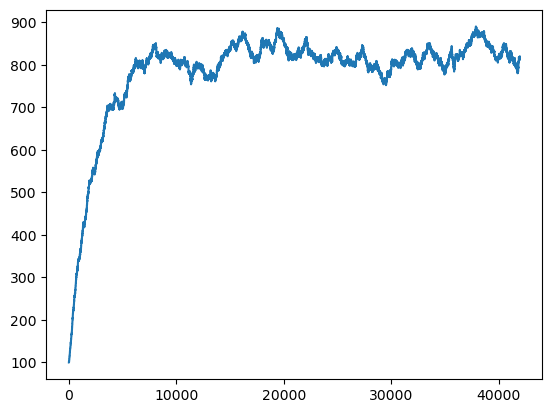

In [18]:
plt.plot(mc_control['l'])

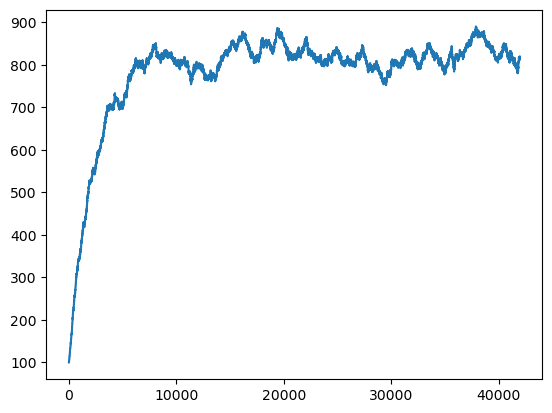

In [19]:
plt.plot(((mc_control['choice_type'] == 'l') - (mc_control['is_replenished'].astype(int))).cumsum() + n_listings)

In [20]:
mc_treat['y'] = (mc_treat[mc_treat['is_customer'] == 1]['choice_type'] == 'l').astype(int)
mc_control['y'] = (mc_control[mc_control['is_customer'] == 1]['choice_type'] == 'l').astype(int)

In [21]:
from sklearn.linear_model import LinearRegression

treat_df = mc_treat[mc_treat['is_customer'] == 1]
treat_df['treated'] = 1
ctrl_df = mc_control[mc_control['is_customer'] == 1]
ctrl_df['treated'] = 0

comb_df = pd.concat([treat_df, ctrl_df])

model = LinearRegression().fit(comb_df[['treated']], comb_df['y'])
print("Treatment Effect:", model.coef_)

model = LinearRegression().fit(comb_df[['l', 'treated']], comb_df['y'])
print("Adjusted Coefficients:", model.coef_)


Treatment Effect: [0.05715909]
Adjusted Coefficients: [0.00043363 0.03671605]


/tmp/ipykernel_300618/2407771517.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  treat_df['treated'] = 1
/tmp/ipykernel_300618/2407771517.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ctrl_df['treated'] = 0


In [22]:
# with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
#     print(mc)

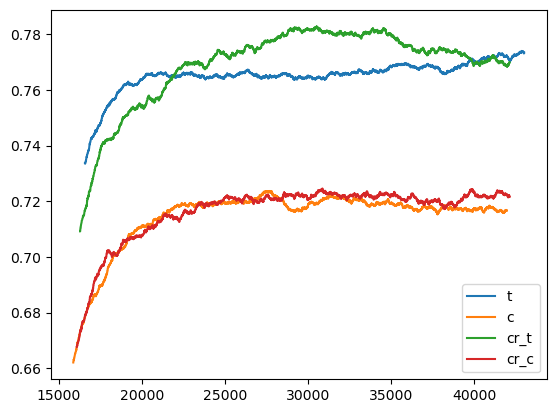

In [23]:
def get_rolling_avg(df, window):
    return (df["choice_type"] != "outside_option").rolling(window=window).mean()

w = 10000

customer_events_t = mc_treat[pd.notnull(mc_treat['choice_type'])]
rolling_avg_t = get_rolling_avg(customer_events_t, w)

customer_events_c = mc_control[pd.notnull(mc_control['choice_type'])]
rolling_avg_c = get_rolling_avg(customer_events_c, w)

customer_events_cr_control = mc_cr[pd.notnull(mc_cr['choice_type']) & (mc_cr['customer_type'] == 'c1_control')]
rolling_avg_cr_control = get_rolling_avg(customer_events_cr_control, int(w/2))

customer_events_cr_treat = mc_cr[pd.notnull(mc_cr['choice_type']) & (mc_cr['customer_type'] == 'c1_treat')]
rolling_avg_cr_treat = get_rolling_avg(customer_events_cr_treat, int(w/2))



plt.plot(rolling_avg_t, label="t")
plt.plot(rolling_avg_c, label="c")
plt.plot(rolling_avg_cr_treat, label="cr_t")
plt.plot(rolling_avg_cr_control, label="cr_c")

plt.legend()


In [25]:
def get_not_null(df):
    df[pd.notnull(df['choice_type'])]

customer_events_t = get_not_null(df)
customer_events_c = mc_control[pd.notnull(mc_control['choice_type'])]


plt.plot(customer_events_t['l'].rolling(window=1000).mean(), label="t")
plt.plot(customer_events_c['l'].rolling(window=1000).mean(), label="c")

NameError: name 'df' is not defined

# Simulations

Setting simulation parameters. Remaining model parameters as defined in mean field parameters.

Define choice set type. If 'alpha', customers sample items into consideration set with prob alpha. If 'finite_k', each customer draws a fixed $k$ number of items into their consideration set.

## Herding

In [17]:
import experiment_helper
import exp_wrapper 

import finite_sim as sim
import finite_sim_wrapper as sim_wrapper

importlib.reload(exp_wrapper)
importlib.reload(experiment_helper)
importlib.reload(sim)
importlib.reload(sim_wrapper) # reload for quicker iteration

events_herding = sim_wrapper.run_all_sims(n_runs, n_listings, T_start, T_end, 
                                  choice_set_type, k,
                                 alpha, epsilon, tau, lams,
                                 **params, herding=True)
est_stats_herding = sim_wrapper.calc_all_ests_stats("sample", T_start, T_end, 
                                            n_listings, tau=tau, 
                                            tsr_est_types=tsr_est_types,
                                            events=events_herding, 
                                            varying_time_horizons=varying_time_horizons,
                                            **params
                                           )
est_stats_herding = est_stats_herding.rename({'cr':"Customer-Side", 'lr':"Product-Side",
                            'tsri_2.0':'TSRI-2', 'tsri_1.0':'TSRI-1',
                             'tsr_est_naive':"TSR-Naive"
                            })

lambda= 0.1
Time elapsed:  5.73
lambda= 1
Time elapsed:  5.53
lambda= 10
Time elapsed:  11.7


/home/ralur/herding-bias/finite_sim.py:277: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  treated_events['treated'] = 1
/home/ralur/herding-bias/finite_sim.py:278: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ctrl_events['treated'] = 0
/home/ralur/herding-bias/finite_sim.py:277: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable

## Competition

In [29]:
events_competition = sim_wrapper.run_all_sims(n_runs, n_listings, T_start, T_end, 
                                  choice_set_type, k,
                                 alpha, epsilon, tau, lams,
                                 **params, herding=False)
est_stats_competition = sim_wrapper.calc_all_ests_stats("sample", T_start, T_end, 
                                            n_listings, tau=tau, 
                                            tsr_est_types=tsr_est_types,
                                            events=events_competition, 
                                            varying_time_horizons=varying_time_horizons,
                                            **params
                                           )
est_stats_competition = est_stats_competition.rename({'cr':"Customer-Side", 'lr':"Product-Side",
                            'tsri_2.0':'TSRI-2', 'tsri_1.0':'TSRI-1',
                             'tsr_est_naive':"TSR-Naive"
                            })

lambda= 0.1
Time elapsed:  49.43
lambda= 1
Time elapsed:  50.13
lambda= 10
Time elapsed:  201.13


# Herding, no recency bias

In [87]:
events_herding_no_recency = sim_wrapper.run_all_sims(n_runs, n_listings, T_start, T_end, 
                                  choice_set_type, k,
                                 alpha, epsilon, tau, lams,
                                 **params, herding=True, recency=False)
est_stats_herding_no_recency = sim_wrapper.calc_all_ests_stats("sample", T_start, T_end, 
                                            n_listings, tau=tau, 
                                            tsr_est_types=tsr_est_types,
                                            events=events_herding_no_recency, 
                                            varying_time_horizons=varying_time_horizons,
                                            **params
                                           )
est_stats_herding_no_recency = est_stats_herding_no_recency.rename({'cr':"Customer-Side", 'lr':"Product-Side",
                            'tsri_2.0':'TSRI-2', 'tsri_1.0':'TSRI-1',
                             'tsr_est_naive':"TSR-Naive"
                            })

lambda= 0.1
Time elapsed:  18.46
lambda= 1
Time elapsed:  6.33
lambda= 10
Time elapsed:  35.33


# Visualizations

## Visualizations: Herding

In [21]:
#sampletotal_stats.csv
#sample_total_stats_herding100.csv
est_stats_herding = pd.read_csv("sampletotal_stats.csv", index_col=["estimator_type", "lambda"])

est_stats_herding = est_stats_herding.rename({'cr':"Customer-Side", 'lr':"Product-Side",
                            'tsri_2.0':'TSRI-2', 'tsri_1.0':'TSRI-1',
                             'tsr_est_naive':"TSR-Naive",
                              'cr_adj':"Customer-Side-Adj",
                              'lr_adj':"Product-Side-Adj",
                              'mrd_avg':"Multiple-Randomization"
                            })

(<Figure size 1000x1000 with 6 Axes>,
 array([[<AxesSubplot:xlabel='Relative user arrival rate $\\lambda/\\tau$', ylabel='Bias'>,
         <AxesSubplot:xlabel='Relative user arrival rate $\\lambda/\\tau$', ylabel='Bias / GTE'>],
        [<AxesSubplot:xlabel='Relative user arrival rate $\\lambda/\\tau$', ylabel='SE'>,
         <AxesSubplot:xlabel='Relative user arrival rate $\\lambda/\\tau$', ylabel='SE / GTE'>],
        [<AxesSubplot:xlabel='Relative user arrival rate $\\lambda/\\tau$', ylabel='RMSE'>,
         <AxesSubplot:xlabel='Relative user arrival rate $\\lambda/\\tau$', ylabel='RMSE / GTE'>]],
       dtype=object))

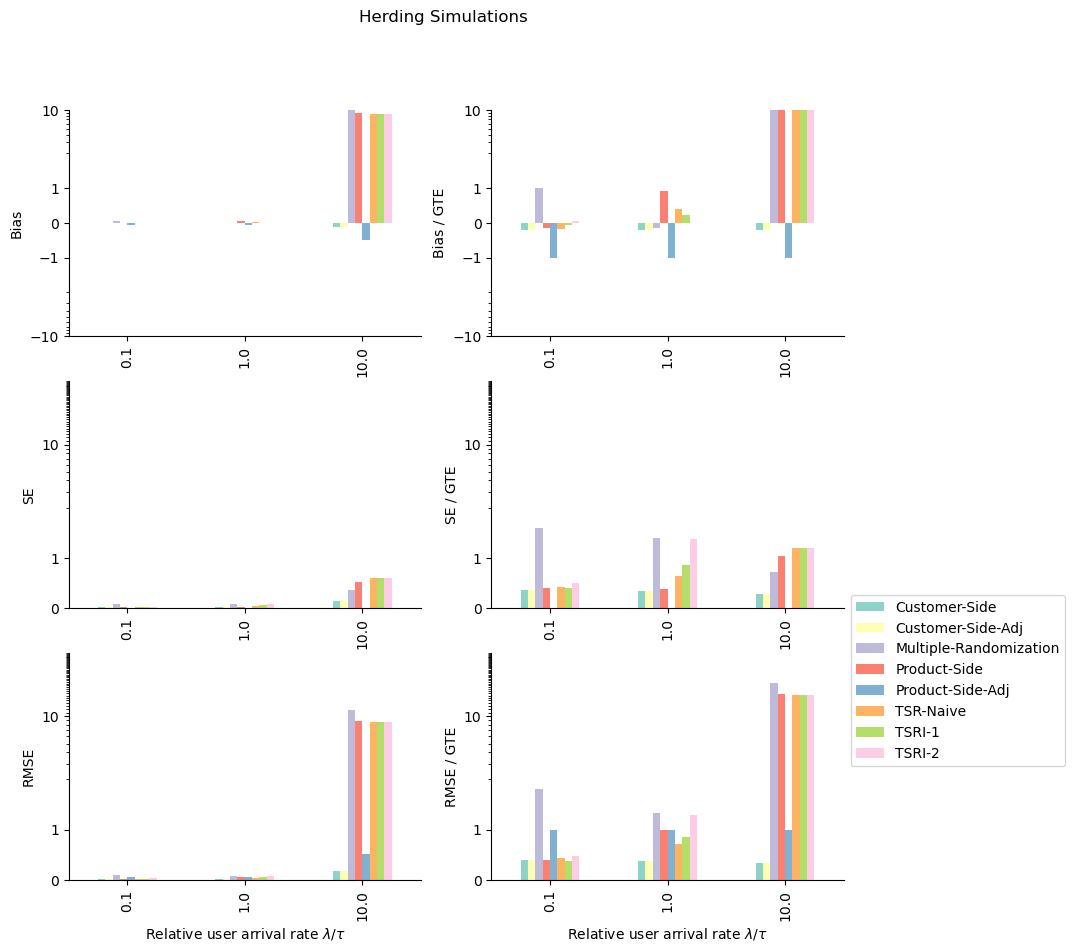

In [22]:
sim_wrapper.plot_all_stats(est_stats_herding, "Herding Simulations", yscale="symlog")

## Visualizations: competition

In [56]:
est_stats_competition = pd.read_csv("sample_total_stats_competition100.csv", index_col=["estimator_type", "lambda"])

est_stats_competition = est_stats_competition.rename({'cr':"Customer-Side", 'lr':"Product-Side",
                            'tsri_2.0':'TSRI-2', 'tsri_1.0':'TSRI-1',
                             'tsr_est_naive':"TSR-Naive"
                            })
#est_stats_competition = est_stats_competition.loc[["Customer-Side", "Product-Side", "TSR-Naive", "TSRI-1", "TSRI-2"]]

(<Figure size 1000x1000 with 6 Axes>,
 array([[<AxesSubplot:xlabel='Relative user arrival rate $\\lambda/\\tau$', ylabel='Bias'>,
         <AxesSubplot:xlabel='Relative user arrival rate $\\lambda/\\tau$', ylabel='Bias / GTE'>],
        [<AxesSubplot:xlabel='Relative user arrival rate $\\lambda/\\tau$', ylabel='SE'>,
         <AxesSubplot:xlabel='Relative user arrival rate $\\lambda/\\tau$', ylabel='SE / GTE'>],
        [<AxesSubplot:xlabel='Relative user arrival rate $\\lambda/\\tau$', ylabel='RMSE'>,
         <AxesSubplot:xlabel='Relative user arrival rate $\\lambda/\\tau$', ylabel='RMSE / GTE'>]],
       dtype=object))

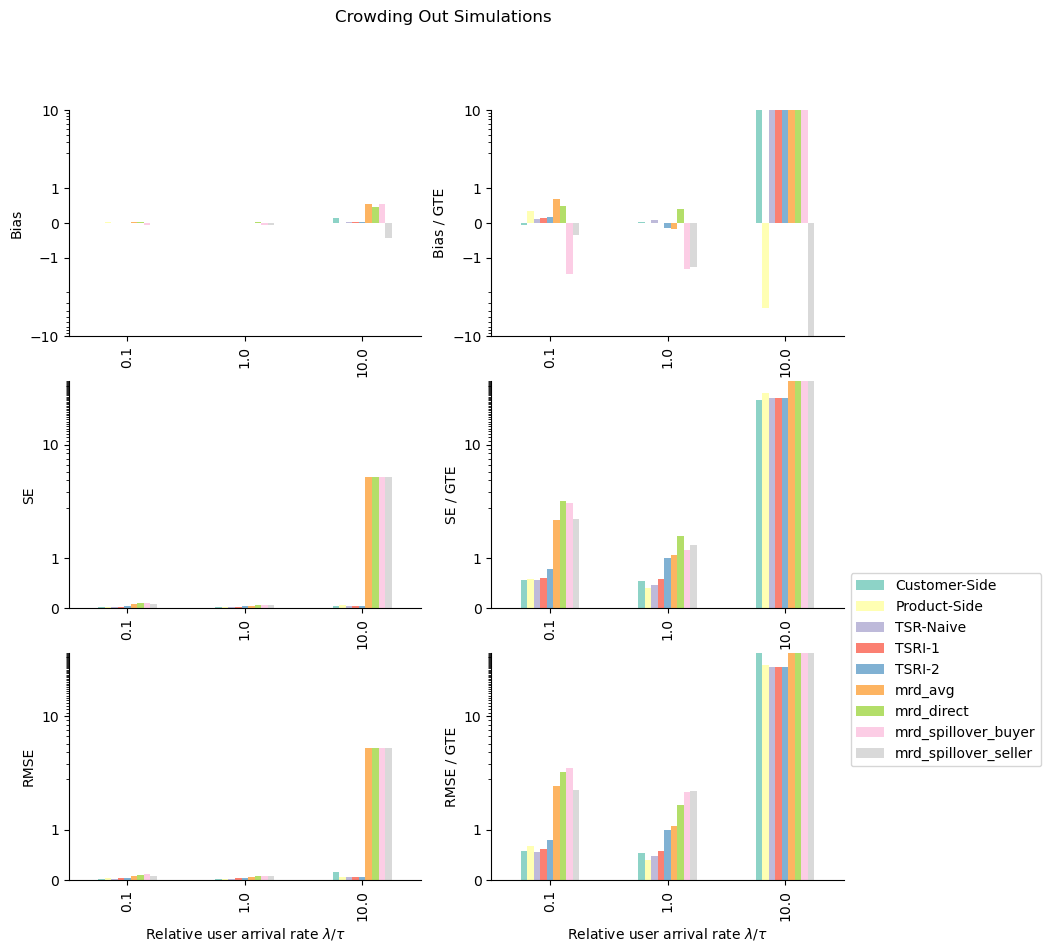

In [57]:
sim_wrapper.plot_all_stats(est_stats_competition, "Crowding Out Simulations", yscale="symlog")

## Visualizations: Herding, no recency

In [89]:
est_stats_herding_no_recency = pd.read_csv("sample_total_stats_herding_no_recency.csv", index_col=["estimator_type", "lambda"])

est_stats_herding_no_recency = est_stats_herding_no_recency.rename({'cr':"Customer-Side", 'lr':"Product-Side",
                            'tsri_2.0':'TSRI-2', 'tsri_1.0':'TSRI-1',
                             'tsr_est_naive':"TSR-Naive"
                            })
est_stats_herding_no_recency = est_stats_herding_no_recency.loc[["Customer-Side", "Product-Side", "TSR-Naive", "TSRI-1", "TSRI-2"]]

(<Figure size 720x720 with 6 Axes>,
 array([[<AxesSubplot:xlabel='Relative user arrival rate $\\lambda/\\tau$', ylabel='Bias'>,
         <AxesSubplot:xlabel='Relative user arrival rate $\\lambda/\\tau$', ylabel='Bias / GTE'>],
        [<AxesSubplot:xlabel='Relative user arrival rate $\\lambda/\\tau$', ylabel='SE'>,
         <AxesSubplot:xlabel='Relative user arrival rate $\\lambda/\\tau$', ylabel='SE / GTE'>],
        [<AxesSubplot:xlabel='Relative user arrival rate $\\lambda/\\tau$', ylabel='RMSE'>,
         <AxesSubplot:xlabel='Relative user arrival rate $\\lambda/\\tau$', ylabel='RMSE / GTE'>]],
       dtype=object))

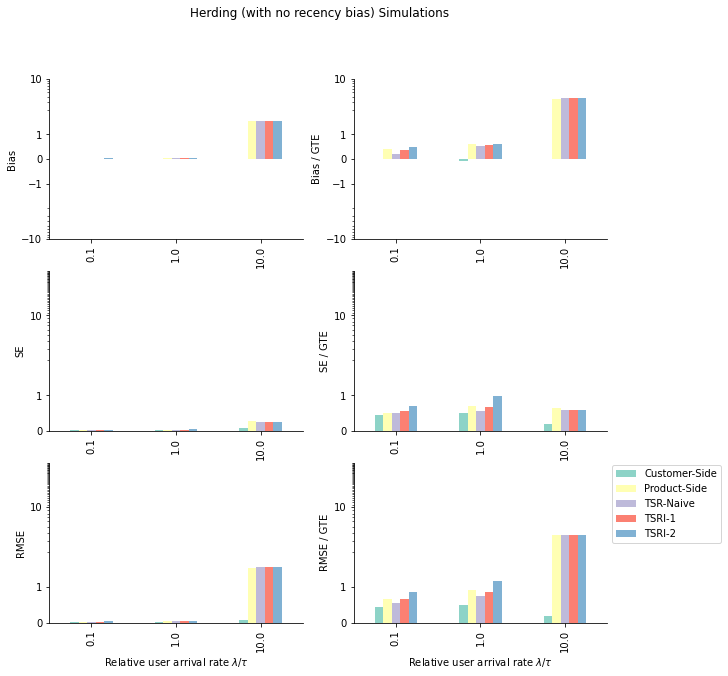

In [90]:
sim_wrapper.plot_all_stats(est_stats_herding_no_recency, "Herding (with no recency bias) Simulations", yscale="symlog")